In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [3]:
import tensorflow as tf

2024-06-07 22:59:40.498430: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 22:59:41.087105: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yw/miniconda3/envs/tf/lib/
2024-06-07 22:59:41.087219: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yw/miniconda3/envs/tf/lib/
2024-06-07 22:59:41.087227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries

In [4]:
import tensorflow.keras.backend as K

In [5]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

In [6]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
#   except RuntimeError as e:
#     print(e)

# data preprocessing

In [7]:
df = pd.read_csv('mugshots/preprocessed.csv')

## preprocessing

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69657 entries, 0 to 69656
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            69657 non-null  object 
 1   Sex           69657 non-null  object 
 2   Height        69657 non-null  object 
 3   Weight        69657 non-null  object 
 4   Hair          69657 non-null  object 
 5   Eyes          69657 non-null  object 
 6   Race          69657 non-null  object 
 7   Sex Offender  69657 non-null  bool   
 8   Offense       69657 non-null  object 
 9   Height_cm     69657 non-null  float64
 10  Weight_kg     69657 non-null  float64
dtypes: bool(1), float64(2), object(8)
memory usage: 5.4+ MB


In [9]:
df.drop(columns=['Height', 'Weight', 'Sex Offender', 'Offense', 'Hair', 'Eyes'], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69657 entries, 0 to 69656
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         69657 non-null  object 
 1   Sex        69657 non-null  object 
 2   Race       69657 non-null  object 
 3   Height_cm  69657 non-null  float64
 4   Weight_kg  69657 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.7+ MB


In [11]:
data = pd.get_dummies(df, columns=['Sex', 'Race'])

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69657 entries, 0 to 69656
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  69657 non-null  object 
 1   Height_cm           69657 non-null  float64
 2   Weight_kg           69657 non-null  float64
 3   Sex_Female          69657 non-null  bool   
 4   Sex_Male            69657 non-null  bool   
 5   Race_Amer Indian    69657 non-null  bool   
 6   Race_Asian          69657 non-null  bool   
 7   Race_Bi-Racial      69657 non-null  bool   
 8   Race_Black          69657 non-null  bool   
 9   Race_Hispanic       69657 non-null  bool   
 10  Race_Not Available  69657 non-null  bool   
 11  Race_White          69657 non-null  bool   
dtypes: bool(9), float64(2), object(1)
memory usage: 2.2+ MB


In [13]:
train_data = data[:int(0.8*len(data))]
val_data = data[int(0.8*len(data)):int(0.9*len(data))]
test_data = data[int(0.9*len(data)):]

train_data = train_data[~train_data['Race_Not Available']]
val_data = val_data[~val_data['Race_Not Available']]
test_data = test_data[~test_data['Race_Not Available']]

In [14]:
len(train_data[train_data['Race_Asian']]), len(val_data[val_data['Race_Asian']]), len(test_data[test_data['Race_Asian']])

(174, 40, 41)

In [15]:
train_data = train_data[train_data['Race_Asian']]
val_data = val_data[val_data['Race_Asian']]
test_data = test_data[test_data['Race_Asian']]

In [16]:
# convert to tuple
train_data = ('mugshots/front/front/'+train_data['ID'],
              'mugshots/side/side/'+train_data['ID'],
               tf.constant(train_data.drop(columns=['ID', 'Weight_kg']).values, dtype=tf.float32),
               tf.constant(train_data['Weight_kg'].values, dtype=tf.float32))
val_data = ('mugshots/front/front/'+val_data['ID'],
            'mugshots/side/side/'+val_data['ID'],
             tf.constant(val_data.drop(columns=['ID', 'Weight_kg']).values, dtype=tf.float32),
             tf.constant(val_data['Weight_kg'].values, dtype=tf.float32))
test_data = ('mugshots/front/front/'+test_data['ID'], 
             'mugshots/side/side/'+test_data['ID'], 
             tf.constant(test_data.drop(columns=['ID', 'Weight_kg']).values, dtype=tf.float32),
             tf.constant(test_data['Weight_kg'].values, dtype=tf.float32))

In [17]:
BATCH_SIZE = 32
N_TRAIN = len(train_data[0])
N_TRAIN

174

In [18]:
# read images file by file path
def read_imgs(file_paths):
    imgs = tf.TensorArray(tf.float32, size=BATCH_SIZE)
    i=0
    for file_path in file_paths:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224))
        img = preprocess_input(img)
        imgs = imgs.write(i, img)
        i+=1
    return imgs.stack()

In [19]:
# run eagerly
# tf.config.run_functions_eagerly(True)
mapper = lambda front, side, x, y: ((read_imgs(front), read_imgs(side), x), y)
train_set = tf.data.Dataset.from_tensor_slices(train_data).shuffle(N_TRAIN).batch(BATCH_SIZE, drop_remainder=True).map(mapper).prefetch(1)
val_set = tf.data.Dataset.from_tensor_slices(val_data).batch(BATCH_SIZE, drop_remainder=True).map(mapper).prefetch(1)
test_set = tf.data.Dataset.from_tensor_slices(test_data).batch(BATCH_SIZE, drop_remainder=True).map(mapper).prefetch(1)

# model

In [20]:
# Data augmentation layers
data_augmentation_front = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomBrightness(factor = (-0.25, 0.1)),  # adjust according to your needs
    tf.keras.layers.RandomContrast(0.5),    # adjust according to your needs
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.1)),        # adjust according to your needs
])
data_augmentation_side = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(factor = (-0.25, 0.1)),  # adjust according to your needs
    tf.keras.layers.RandomContrast(0.5),    # adjust according to your needs
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.1)),        # adjust according to your needs
])

In [21]:
def augment_and_display(front_sample, side_sample):
    # Convert numpy arrays to tensors and normalize the images if they aren't already
    front_image = tf.convert_to_tensor(front_sample, dtype=tf.float32) 
    side_image = tf.convert_to_tensor(side_sample, dtype=tf.float32)

    # Apply augmentation
    augmented_front = data_augmentation_front(front_image[tf.newaxis, ...], training = True)/255.0
    augmented_side = data_augmentation_side(side_image[tf.newaxis, ...], training = True)/255.0

    # Ensure the augmented images are still in [0, 1] range
    augmented_front = tf.clip_by_value(augmented_front, 0, 1)
    augmented_side = tf.clip_by_value(augmented_side, 0, 1)

    # Prepare the plots
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].imshow(front_image/255.0)
    ax[0, 0].set_title("Original Front")
    ax[0, 0].axis('off')

    ax[0, 1].imshow(side_image/255.0)
    ax[0, 1].set_title("Original Side")
    ax[0, 1].axis('off')

    ax[1, 0].imshow(augmented_front[0])
    ax[1, 0].set_title("Augmented Front")
    ax[1, 0].axis('off')

    ax[1, 1].imshow(augmented_side[0])
    ax[1, 1].set_title("Augmented Side")
    ax[1, 1].axis('off')

    plt.show()


In [23]:
tf.get_logger().setLevel('ERROR')

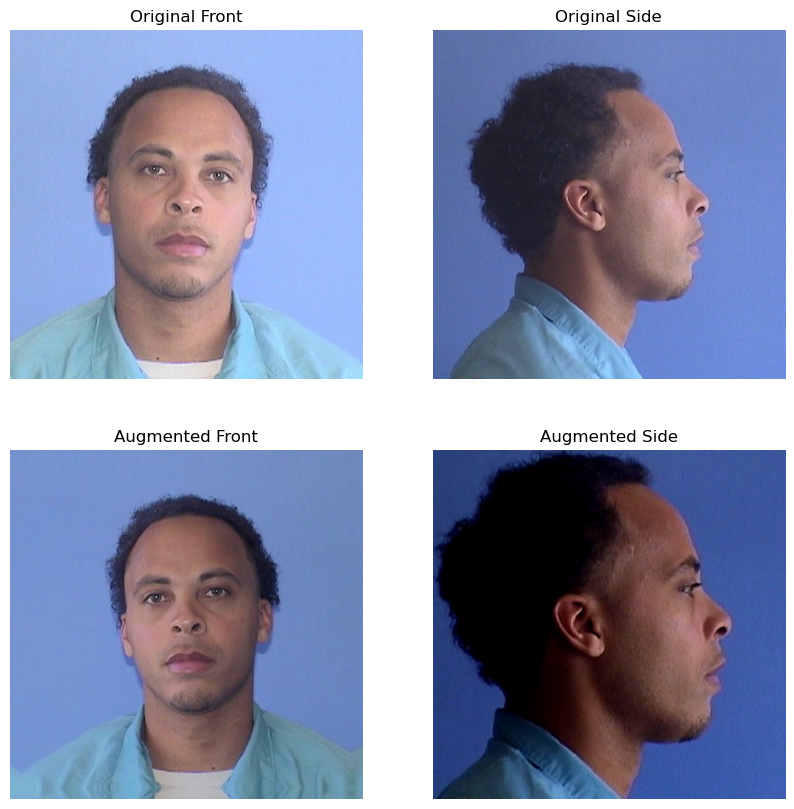

In [24]:
#augmentation image 출력해보기
import os
import pandas as pd
from matplotlib import pyplot as plt
import random

class DataLoader():

    def __init__(self, base_dir):
        self.base_dir = base_dir
        self.front_files = os.listdir(os.path.join(base_dir, 'front/front'))
        self.side_files = os.listdir(os.path.join(base_dir, 'side/side'))
        self.labels = pd.read_csv(os.path.join(base_dir, 'labels_utf8.csv'), header=0, index_col=None).to_dict()
        self.num_labeled_samples = len(self.labels['ID'])  # 69827

    def get_sample(self):
        i = random.randint(0, self.num_labeled_samples-1)
        label = {}
        for key in self.labels.keys():
            label[key] = self.labels[key][i]
        front_image = plt.imread(os.path.join(self.base_dir, 'front/front', label['ID']))
        side_image = plt.imread(os.path.join(self.base_dir, 'side/side', label['ID']))
        
        return front_image, side_image, label

if __name__ == '__main__':
    data_loader = DataLoader('mugshots')
    front_sample, side_sample, label = data_loader.get_sample()

    augment_and_display(front_sample, side_sample)

    


In [25]:
# # create model
# base_model_front = EfficientNetB0(include_top=False, input_shape=(224, 224, 3))
# base_model_front._name = 'EfficientNetB0_front'

# model_front = tf.keras.Sequential([
#     data_augmentation_front, 
#     base_model_front,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(1)
# ])

# for layer in base_model_front.layers:
#     layer._name = layer.name + "_front"

# for layer in model_front.layers:
#     layer._name = layer.name + "_front"

# model_front.input._name = model_front.input.name + "_front"

# Define input with specific name
inputs = tf.keras.Input(shape=(224, 224, 3), name="input_front")
# Add the base model, with preprocessing included
base_model_front = EfficientNetB0(include_top=False, input_shape=(224, 224, 3))
base_model_front._name = 'EfficientNetB0_front'
x = data_augmentation_front(inputs)
x = base_model_front(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1)(x)

# Create the model
model_front = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_front")

In [26]:
# create model
# base_model_side = EfficientNetB0(include_top=False, input_shape=(224, 224, 3))
# base_model_side._name = 'EfficientNetB0_side'


# model_side = tf.keras.Sequential([
#     data_augmentation_side,
#     base_model_side,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(1)
# ])

# for layer in base_model_side.layers:
#     layer._name = layer.name + "_side"

# for layer in model_side.layers:
#     layer._name = layer.name + "_side"

# model_side.input._name = model_side.input.name + "_side"

inputs = tf.keras.Input(shape=(224, 224, 3), name="input_side")
base_model_side = EfficientNetB0(include_top=False, input_shape=(224, 224, 3))
base_model_side._name = 'EfficientNetB0_side'
x = data_augmentation_side(inputs)
x = base_model_side(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1)(x)

# Create the model
model_side = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_side")

In [27]:
model_structured = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(train_data[2].shape[1:])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

for layer in model_structured.layers:
    layer._name = layer.name + "_structured"

In [72]:
_x = tf.keras.layers.concatenate([model_front.layers[-2].output, model_side.layers[-2].output, model_structured.layers[-3].output])
top_model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])
_x = top_model(_x)

In [73]:
model = tf.keras.Model(inputs=[model_front.input, model_side.input, model_structured.input], outputs=_x)

In [80]:
model.load_weights('big_ensemble_0.h5')

In [81]:
len(base_model_side.layers)

238

In [88]:
base_model_front.trainable = True
base_model_side.trainable = True
model_structured.trainable = True

# for layer in base_model_front.layers:
#     layer.trainable = False
# for layer in base_model_side.layers:
#     layer.trainable = False
# for layer in base_model_front.layers[-80:]:
#     layer.trainable = True
# for layer in base_model_side.layers[-80:]:
#     layer.trainable = True

model.compile(optimizer="adam", loss='mse', metrics=['mae'])
K.set_value(model.optimizer.learning_rate, 0.01*model.optimizer.learning_rate)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 batch_normalization_structured  (None, 10)          40          ['input_3[0][0]']                
  (BatchNormalization)                                                                            
                                                                                                  
 dense_2_structured (Dense)     (None, 64)           704         ['batch_normalization_structured[
                                                                 0][0]']                          
                                                                                            

In [92]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [93]:
history = model.fit(train_set, validation_data=val_set, epochs=100, callbacks=[early_stopping])

Epoch 1/100
5/5 [==============================] - 4s 865ms/step - loss: 6094.8413 - mae: 76.8985 - val_loss: 6240.3589 - val_mae: 76.7851
Epoch 2/100
5/5 [==============================] - 4s 850ms/step - loss: 5988.4634 - mae: 76.2519 - val_loss: 6239.8838 - val_mae: 76.7846
Epoch 3/100
5/5 [==============================] - 4s 830ms/step - loss: 6063.3672 - mae: 76.7335 - val_loss: 6239.8750 - val_mae: 76.7869
Epoch 4/100
5/5 [==============================] - 4s 769ms/step - loss: 6084.6440 - mae: 76.8608 - val_loss: 6242.4277 - val_mae: 76.8074
Epoch 5/100
5/5 [==============================] - 4s 781ms/step - loss: 6023.0518 - mae: 76.3786 - val_loss: 6245.4248 - val_mae: 76.8312
Epoch 6/100
5/5 [==============================] - 4s 768ms/step - loss: 5998.9336 - mae: 76.3415 - val_loss: 6247.9727 - val_mae: 76.8521
Epoch 7/100
5/5 [==============================] - 4s 775ms/step - loss: 6034.6592 - mae: 76.4376 - val_loss: 6249.8115 - val_mae: 76.8684
Epoch 8/100
5/5 [==========

KeyboardInterrupt: 

In [77]:
def modelplot(history, data, val_data):
    plt.plot(history.history[data])
    plt.plot(history.history[val_data])
    plt.title('Model'+ data)
    plt.ylabel(data)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()



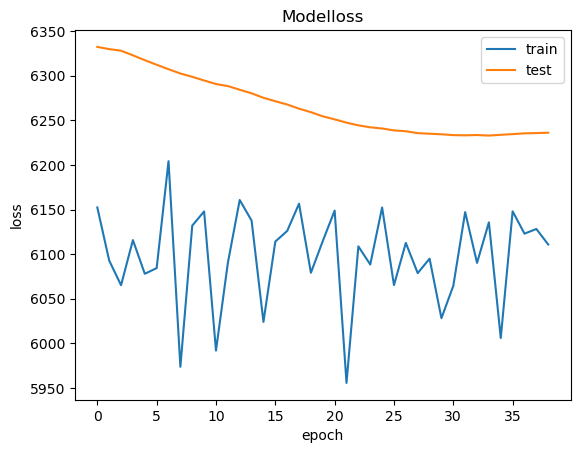

In [78]:
modelplot(history, 'loss', 'val_loss')

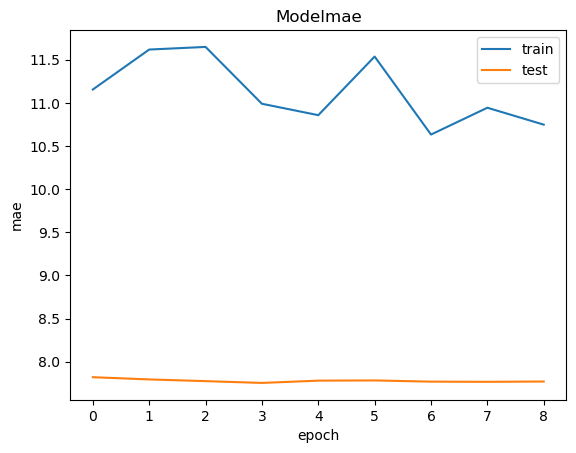

In [51]:
modelplot(history, 'mae', 'val_mae')

In [52]:
model.evaluate(test_set)

1/1 [==============================] - 0s 260ms/step - loss: 51.5735 - mae: 5.6978


[51.57347869873047, 5.697763442993164]

In [79]:
model.save_weights('big_ensemble_0.h5')